In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# path = '/global/homes/e/ecastori/PostBorn/'
path = '../PostBornEma/'

In [3]:
data = np.loadtxt(path+'FFT_k-1Pk.dat',skiprows=2)

#----------------------#
n         = data[:,0]
Re_c_n    = data[:,1]
Im_c_n    = data[:,2]
Re_nu_n   = data[:,3]
Im_nu_n   = data[:,4]
#----------------------#

c_n  = Re_c_n  + 1j * Im_c_n
nu_n = Re_nu_n + 1j * Im_nu_n

In [4]:
### When reading Ema's files for the first time

# data = np.loadtxt(path+'Il_nu_t_new1.dat',skiprows=1)
# # data = np.loadtxt(path+'Il_nu_t.dat',skiprows=1)

# #----------------------#
# ell       = data[:,0]
# nn        = data[:,1]
# tt        = data[:,2]
# Re_I      = data[:,3]
# Im_I      = data[:,4]
# #----------------------#

# I_ = Re_I + 1j * Im_I

# # np.save('../PostBornEma/Il_nu_t_new1-ell-nn-tt.dat', np.stack((ell, nn, tt), axis=1))
# # np.save('../PostBornEma/Il_nu_t_new1-ReI-ImI.dat', np.stack((Re_I, Im_I), axis=1))

In [7]:
data =  np.load(path+'Il_nu_t_new1-ell-nn-tt.npy')
ell       = data[:,0]
nn        = data[:,1]
tt        = data[:,2]
#----------------------#

data =  np.load(path+'Il_nu_t_new1-ReI-ImI.npy')
Re_I      = data[:,0]
Im_I      = data[:,1]
#----------------------#

I_ = Re_I + 1j * Im_I

In [8]:
data = np.loadtxt(path+'GG_weights.dat',skiprows=2)
t1   = data[:,0]
w1   = data[:,1]

In [9]:
print(np.unique(tt)-t1)

[ 3.30000000e-12  1.99999956e-13  3.30000001e-11 -1.89999999e-11
 -2.10000003e-11  4.69999994e-11 -2.40000001e-10  1.20000000e-10
 -1.30000000e-10 -4.60000000e-10 -7.00000023e-11  4.79999998e-10
 -7.00000058e-11 -4.90000006e-10 -4.89999999e-10  3.10000005e-10
 -2.49999993e-10  6.00000050e-11  6.00000050e-11 -1.70000000e-10
  3.80000000e-09 -4.79999999e-09  7.00000002e-10 -4.89999999e-09
  1.20000002e-09  2.99999997e-10  2.20000002e-09 -4.29999999e-09
 -1.00000008e-10  4.89999999e-09  3.70000000e-09  4.00000000e-09
  1.00000008e-10 -4.60000005e-09 -4.90000002e-09 -1.09999998e-09
  4.20000001e-09 -8.00000011e-10 -3.19999999e-09 -2.00000000e-09
 -4.00000000e-09 -2.00000017e-10 -9.00000019e-10 -2.00000000e-09
 -3.00000025e-10  1.40000000e-09 -1.79999998e-09 -1.39999995e-09
 -1.19999999e-09 -2.20000002e-09  2.19999996e-09  1.19999999e-09
  1.40000000e-09  1.79999993e-09 -1.39999989e-09  2.99999914e-10
  1.99999994e-09  8.99999963e-10  2.00000017e-10  4.00000000e-09
  2.00000005e-09  3.20000

In [10]:
#cosmology
h         = 0.6770
omega_cdm = 0.11923
omega_b   = 0.02247
Omega_b   = omega_b/h**2
Omega_cdm = omega_cdm/h**2
Omega_m   = Omega_b+Omega_cdm
ns        = 0.96824
A0        = 2.10732*10**(-9)

#dictionary for class
cosmo_dict={'h': h,
'omega_b' : omega_b,
'omega_cdm': omega_cdm,
'A_s'    : A0,
'n_s'    : ns,
'k_pivot' : 0.05}
print(cosmo_dict)

# speed of light
c      = 299792458./1000. # km/s

#prefactor for Cl_kk computation from Cl_dd
prefac = 1.5*Omega_m*(100.)**2/c**2 #without h

{'h': 0.677, 'omega_b': 0.02247, 'omega_cdm': 0.11923, 'A_s': 2.10732e-09, 'n_s': 0.96824, 'k_pivot': 0.05}


In [11]:
from classy import Class
cosmo = Class()
cosmo.set(cosmo_dict)
cosmo.compute()
cosmo_b               = cosmo.get_background()

class_z               = cosmo_b['z'][::-1]
class_chi             = cosmo_b['comov. dist.'][::-1]
class_D               = cosmo_b['gr.fac. D'][::-1]#/cosmo_b['gr.fac. D'][-1]

derivParams           = cosmo.get_current_derived_parameters(['z_rec'])
z_cmb                 = derivParams['z_rec']


from scipy.interpolate import interp1d
from scipy.interpolate import InterpolatedUnivariateSpline as ius
chi_z = interp1d(class_z,class_chi*h, bounds_error=False, fill_value=0)
z_chi = interp1d(class_chi*h,class_z, bounds_error=False, fill_value=0)   # Mpc/h
D_chi = interp1d(class_chi*h,class_D, bounds_error=False, fill_value=0)    # growth
D_z   = interp1d(class_z,class_D, bounds_error=False, fill_value=0)
# chi_cmb
chi_cmb = chi_z(z_cmb)



In [12]:
print(chi_z(1100),chi_z(z_cmb))

9416.06644934157 9414.597956961135


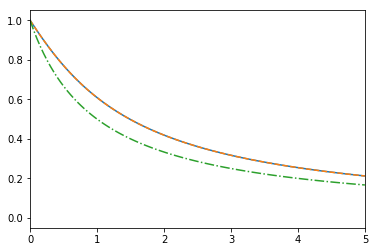

array(1.)

In [13]:
z = np.linspace(0,5,100)
plt.figure()
plt.plot(class_z,class_D,ls='-')
plt.plot(z,D_z(z),ls='--')
plt.plot(z,1/(1+z),ls='-.')
plt.xlim(0,5)
plt.show()
D_z(0)

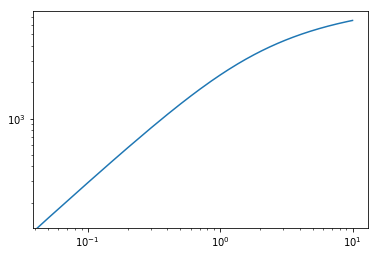

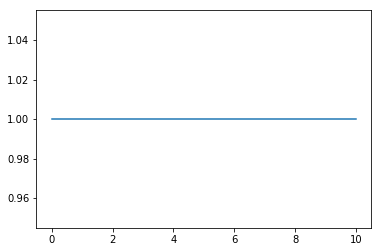

In [14]:
z=np.linspace(0.,10,200)
plt.figure()
plt.loglog(z,chi_z(z))
plt.show()
plt.figure()
plt.plot(z,D_z(z)/D_chi(chi_z(z)))
plt.show()
# plt.figure()
# plt.loglog(z,)
# plt.show()
# plt.figure()
# plt.loglog(z,z_chi(chi_z(z)))
# plt.show()

In [15]:
D_chi(chi_z(0.1))

array(0.94886829)

# Setup

In [14]:
def set_kernel(chi_max):
    def kernel(chi):
        return (1.+z_chi(chi))*D_chi(chi)
    return kernel

In [15]:
D = set_kernel(chi_cmb)

In [16]:
ell

array([   2.,    2.,    2., ..., 2000., 2000., 2000.])

In [17]:
ell_ = np.unique(ell)
nu_n_= np.unique(nu_n) 
t_=np.unique(tt)
assert(np.allclose(t_,t1))

print(nu_n_)
print(ell_)
print(np.unique(tt))
print(len(nu_n_),len(n),len(c_n),len(t_))
print(len(tt),len(I_))

[-1.9-27.94471j   -1.9-27.665263j  -1.9-27.385816j  -1.9-27.106369j
 -1.9-26.826921j  -1.9-26.547474j  -1.9-26.268027j  -1.9-25.98858j
 -1.9-25.709133j  -1.9-25.429686j  -1.9-25.150239j  -1.9-24.870792j
 -1.9-24.591345j  -1.9-24.311898j  -1.9-24.03245j   -1.9-23.753003j
 -1.9-23.473556j  -1.9-23.194109j  -1.9-22.914662j  -1.9-22.635215j
 -1.9-22.355768j  -1.9-22.076321j  -1.9-21.796874j  -1.9-21.517427j
 -1.9-21.237979j  -1.9-20.958532j  -1.9-20.679085j  -1.9-20.399638j
 -1.9-20.120191j  -1.9-19.840744j  -1.9-19.561297j  -1.9-19.28185j
 -1.9-19.002403j  -1.9-18.722956j  -1.9-18.443509j  -1.9-18.164061j
 -1.9-17.884614j  -1.9-17.605167j  -1.9-17.32572j   -1.9-17.046273j
 -1.9-16.766826j  -1.9-16.487379j  -1.9-16.207932j  -1.9-15.928485j
 -1.9-15.649038j  -1.9-15.36959j   -1.9-15.090143j  -1.9-14.810696j
 -1.9-14.531249j  -1.9-14.251802j  -1.9-13.972355j  -1.9-13.692908j
 -1.9-13.413461j  -1.9-13.134014j  -1.9-12.854567j  -1.9-12.575119j
 -1.9-12.295672j  -1.9-12.016225j  -1.9-11.736778j

In [160]:
# m=0
# I_array=np.zeros((len(ell_),len(nu_n_),len(t_)),dtype=np.complex64)
# I2D = np.zeros((len(ell_),len(nu_n_),len(t_),len(t_)),dtype=np.complex64)
# for ii,ll in enumerate(ell_):
#     for jj, nu in enumerate(nu_n_):
#             #for kk, _ in enumerate(t_):
#         I_array[ii,jj,:]=I_[m:m+len(t_)]
#         _, I2D_ = np.meshgrid(t_,I_array[ii,jj])
#         I2D[ii][jj] = I2D_
#         m+=len(t_)
m=0
I2D = np.zeros((len(ell_),len(nu_n_),len(t_),len(t_)),dtype=np.complex64)
for ii,ll in enumerate(ell_):
    for jj, nu in enumerate(nu_n_):
        I2D[ii][jj] = np.meshgrid(t_,I_[m:m+len(t_)])[1]
        m+=len(t_)

# Integrals here

In [21]:
from scipy.integrate import simps, quadrature
from scipy.interpolate import interp1d
import time


In [22]:
r2d, t2d = np.meshgrid(t_,t_)
w11, w12 = np.meshgrid(w1,w1)
begin=time.time()
resultv=[]
for ii,ll in enumerate(ell_):
    if ii%20 ==0: print(ii)
    res1=[]
    for jj, nu in enumerate(nu_n_):
        #_, I2D = np.meshgrid(t_,I_array[ii,jj])
        integrand=(1.-r2d*t2d)/t2d*(1.-r2d)/r2d*I2D[ii][jj]*D(r2d*t2d*chi_cmb)*D(r2d*chi_cmb)*(r2d*chi_cmb)**(-nu)
        res1+=[np.sum(w11*w12*integrand)]
    resultv+=[np.real(np.sum(res1[0:-1]*c_n[0:-1]*2.)+res1[-1]*c_n[-1])]
print('Time taken = ', time.time()-begin)

Clv = np.real(np.asarray(resultv))*4./np.pi**2*prefac**2/4.


0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
Time taken =  103.06474280357361


In [ ]:
# ###Introduce a general kernel here 

# def Wkernel(xi, xmax):
#     return (xmax - xi)/(xmax*xi) * (xmax > xi)

# # def Wout(r, xmax):
# #     x1 = r*xmax
# #     return (xmax - x1)/(xmax*x1) * (xmax > x1)

# # def Win(t, r, xmax):
# #     x2 = r*t*xmax
# #     return (xmax - x2)/(xmax*x2) * (xmax > x2)


# r2d, t2d = np.meshgrid(t_,t_)
# w11, w12 = np.meshgrid(w1,w1)
# begin=time.time()
# result=[]
# for ii,ll in enumerate(ell_):
#     if ii%20 ==0: print(ii)
#     res1=[]
#     for jj, nu in enumerate(nu_n_):
#         #_, I2D = np.meshgrid(t_,I_array[ii,jj])
#         ww = Wkernel(r2d*chi_cmb, chi_cmb) *Wkernel(r2d*t2d*chi_cmb, chi_cmb)
#         integrand=ww*I2D[ii][jj]*D(r2d*t2d*chi_cmb)*D(r2d*chi_cmb)*(r2d*chi_cmb)**(1-nu)
#         res1+=[np.sum(w11*w12*integrand)]
#     result+=[np.real(np.sum(res1[0:-1]*c_n[0:-1]*2.)+res1[-1]*c_n[-1])]
# print('Time taken = ', time.time()-begin)
# Cl2=chi_cmb * np.real(np.asarray(result))*4./np.pi**2*prefac**2/4.


In [ ]:
# # def Wout(r, xmax):
# #     x1 = r*xmax
# #     return (xmax - x1)/(xmax*x1) * (xmax > x1)

# # def Win(t, r, xmax):
# #     x2 = r*t*xmax
# #     return (xmax - x2)/(xmax*x2) * (xmax > x2)

# def Wkernel(xi, xmax):
#     return (xmax - xi)/(xmax*xi) * (xmax > xi)


# r2d, t2d = np.meshgrid(t_,t_)
# w11, w12 = np.meshgrid(w1,w1)
# begin=time.time()
# result=[]
# lmax = 10
# for ii,ll in enumerate(ell_[:lmax]):
#     if ii%20 ==0: print(ii)
#     res1, res2=[], []
#     for jj, nu in enumerate(nu_n_):
# #         ww = Wout(r2d, chi_cmb) *Win(t2d, r2d, chi_cmb)
# #         integrand=ww*I2D[ii][jj]*D(r2d*t2d*chi_cmb)*D(r2d*chi_cmb)*(r2d*chi_cmb)**(1-nu)
# #         res1+=[np.sum(w11*w12*integrand)]
    
# #         ww = Wout(r2d, chi_cmb) *Win(1/t2d, r2d, chi_cmb)
# #         integrand=ww*I2D[ii][jj]*D(r2d*1/t2d*chi_cmb)*D(r2d*chi_cmb)*(r2d*chi_cmb)**(1-nu) * t2d**(nu-2)
# #         res2+=[np.sum(w11*w12*integrand)]    
# #     r1 = np.real(np.sum(res1[0:-1]*c_n[0:-1]*2.)+res1[-1]*c_n[-1])
# #     r2 = np.real(np.sum(res2[0:-1]*c_n[0:-1]*2.)+res2[-1]*c_n[-1])
# #     result2 += [r1+r2]

#         chi1fac = Wkernel(r2d*chi_cmb, chi_cmb)*D(r2d*chi_cmb)*(r2d*chi_cmb)**(1-nu)
#         chi2fac = Wkernel(t2d*r2d*chi_cmb, chi_cmb)*D(r2d*t2d*chi_cmb) + \
#                         Wkernel(1/t2d*r2d*chi_cmb, chi_cmb)*D(r2d*1/t2d*chi_cmb)* t2d**(nu-2)

#         integrand = chi1fac * chi2fac * I2D[ii][jj]
#         res1+=[np.sum(w11*w12*integrand)]
    
#     result += [np.real(np.sum(res1[0:-1]*c_n[0:-1]*2.)+res1[-1]*c_n[-1])]
# Cl3=chi_cmb * np.real(np.asarray(result))*4./np.pi**2*prefac**2/8.

# print('Time taken = ', time.time()-begin)

In [ ]:
# ### Try with the auto-spectra without symmetrizing so that we check the second term of Eq. 3.05
# ##Also, no need to estimate the kernels again and again since some terms are independent of \ell and \nu.
# ##This way we reduce calls to interpolate and stuff


# def Wkernel(xi, xmax):
#     return (xmax - xi)/(xmax*xi) * (xmax > xi)


# r2d, t2d = np.meshgrid(t_,t_)
# w11, w12 = np.meshgrid(w1,w1)
# begin=time.time()
# result=[]
# lmax = ell_.size 
# chi1fac0 = Wkernel(r2d*chi_cmb, chi_cmb)*D(r2d*chi_cmb)
# chi2fac00 = Wkernel(t2d*r2d*chi_cmb, chi_cmb)*D(r2d*t2d*chi_cmb) 
# chi2fac01 = Wkernel(1/t2d*r2d*chi_cmb, chi_cmb)*D(r2d*1/t2d*chi_cmb)

# for ii,ll in enumerate(ell_[:lmax]):
#     if ii%20 ==0: print(ii)
#     res1, res2=[], []
#     for jj, nu in enumerate(nu_n_):

#         chi1fac = chi1fac0*(r2d*chi_cmb)**(1-nu)
#         chi2fac = chi2fac00 + chi2fac01* t2d**(nu-2)

#         integrand = chi1fac * chi2fac * I2D[ii][jj]
#         res1+=[np.sum(w11*w12*integrand)]
    
#     result += [np.real(np.sum(res1[0:-1]*c_n[0:-1]*2.)+res1[-1]*c_n[-1])]
# Cl3=chi_cmb * np.real(np.asarray(result))*4./np.pi**2*prefac**2/8.

# print('Time taken = ', time.time()-begin)

In [140]:
### Try with the auto-spectra without symmetrizing so that we check the second term of Eq. 3.05
##Also, no need to estimate the kernels again and again since they are independent of \ell and \nu
##This way we reduce calls to interpolate and stuff
##Well, some things depend on \nu so Use \nu as the third axes so that all the \chi kernels can be estimated beforehand

def Wkernel(xi, xmax):
    return (xmax - xi)/(xmax*xi) * (xmax > xi) * (1.+z_chi(xi))


begin=time.time()

r2d, t2d = np.meshgrid(t_,t_)
w11, w12 = np.meshgrid(w1,w1)
I2D2 = np.swapaxes(I2D, 2, 3) #order of 'r' and 't' is confusing to me

result=[]

chi1fac0 = (Wkernel(r2d*chi_cmb, chi_cmb)*D_chi(r2d*chi_cmb)).reshape(*r2d.shape, 1)
chi1fac0 = chi1fac0 *(r2d*chi_cmb).reshape(*r2d.shape, 1)**(1-nu_n_.reshape(1, 1, -1))

chi2fac00 = (Wkernel(t2d*r2d*chi_cmb, chi_cmb)*D_chi(r2d*t2d*chi_cmb)).reshape(*r2d.shape, 1)
chi2fac01 = (Wkernel(1/t2d*r2d*chi_cmb, chi_cmb)*D_chi(r2d*1/t2d*chi_cmb)).reshape(*r2d.shape, 1)
chi2fac01 = chi2fac01 * t2d.reshape(*r2d.shape, 1)**(nu_n_.reshape(1, 1, -1)-2)
chi2fac0 = chi2fac00 + chi2fac01
w11, w12 = w11.reshape(*w11.shape, 1), w12.reshape(*w12.shape, 1)

lmax = ell.size
for ii,ll in enumerate(ell_[:lmax]):
    if ii%20 ==0: print(ii) 
        
    res1 = np.sum(w11*w12*chi1fac0* chi2fac0*I2D2[ii].T, axis=(0, 1))
    
    result += [np.real(np.sum(res1[0:-1]*c_n[0:-1]*2.)+res1[-1]*c_n[-1])]
Cl3=chi_cmb * np.real(np.asarray(result))*4./np.pi**2*prefac**2/8.

print('Time taken = ', time.time()-begin)

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
Time taken =  6.1029746532440186


In [161]:
cn2 = c_n.copy()
cn2[:-1] *=2

m=0
I2Dcn = np.zeros((len(ell_),len(nu_n_),len(t_),len(t_)),dtype=np.complex64)
for ii,ll in enumerate(ell_):
    for jj, nu in enumerate(nu_n_):
        I2Dcn[ii][jj] = np.meshgrid(t_,I_[m:m+len(t_)]*cn2[ii])[1]
        m+=len(t_)

MemoryError: 

In [ ]:
### Try with the auto-spectra without symmetrizing so that we check the second term of Eq. 3.05
##Also, no need to estimate the kernels again and again since they are independent of \ell and \nu
##This way we reduce calls to interpolate and stuff
##Well, some things depend on \nu so Use \nu as the third axes so that all the \chi kernels can be estimated beforehand

def Wkernel(xi, xmax):
    return (xmax - xi)/(xmax*xi) * (xmax > xi) * (1.+z_chi(xi))


begin=time.time()

r2d, t2d = np.meshgrid(t_,t_)
w11, w12 = np.meshgrid(w1,w1)
I2D2 = np.swapaxes(I2D, 2, 3) #order of 'r' and 't' is confusing to me

result=[]

chi1fac0 = (Wkernel(r2d*chi_cmb, chi_cmb)*D_chi(r2d*chi_cmb)).reshape(*r2d.shape, 1)
chi1fac0 = chi1fac0 *(r2d*chi_cmb).reshape(*r2d.shape, 1)**(1-nu_n_.reshape(1, 1, -1))

chi2fac00 = (Wkernel(t2d*r2d*chi_cmb, chi_cmb)*D_chi(r2d*t2d*chi_cmb)).reshape(*r2d.shape, 1)
chi2fac01 = (Wkernel(1/t2d*r2d*chi_cmb, chi_cmb)*D_chi(r2d*1/t2d*chi_cmb)).reshape(*r2d.shape, 1)
chi2fac01 = chi2fac01 * t2d.reshape(*r2d.shape, 1)**(nu_n_.reshape(1, 1, -1)-2)
chi2fac0 = chi2fac00 + chi2fac01
w11, w12 = w11.reshape(*w11.shape, 1), w12.reshape(*w12.shape, 1)

lmax = ell.size
for ii,ll in enumerate(ell_[:lmax]):
    if ii%20 ==0: print(ii) 
        
    res1 = np.sum(w11*w12*chi1fac0* chi2fac0*I2D2[ii].T, axis=(0, 1))
    
    result += [np.real(np.sum(res1[0:-1]*c_n[0:-1]*2.)+res1[-1]*c_n[-1])]
Cl4=chi_cmb * np.real(np.asarray(result))*4./np.pi**2*prefac**2/8.

print('Time taken = ', time.time()-begin)

(2, 500)

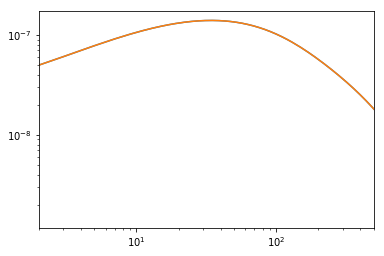

In [141]:
plt.figure()
plt.loglog(ell_,(ell_*(ell_+1.))**2*Clv/(2.*np.pi))
# plt.loglog(ell_[:lmax],(ell_[:lmax]*(ell_[:lmax]+1.))**2*Cl2[:lmax]/(2.*np.pi))
plt.loglog(ell_[:lmax],(ell_[:lmax]*(ell_[:lmax]+1.))**2*Cl3[:lmax]/(2.*np.pi))
# plt.loglog(ell_[:lmax],(ell_[:lmax]*(ell_[:lmax]+1.))**2*Cl33[:lmax]/(2.*np.pi))
plt.xlim(2,500)

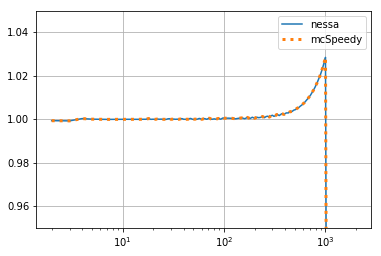

In [142]:
ll,clpp,clpp2 = np.loadtxt('class_ouput.out')

plt.figure()#
plt.semilogx(ell_,Clv/np.interp(ell_,ll,clpp), label='nessa')
# plt.semilogx(ell_,Cl2/np.interp(ell_,ll,clpp), ls="--", lw=2, label='genkern')
plt.semilogx(ell_,Cl3/np.interp(ell_,ll,clpp), ls=":", lw=3, label='mcSpeedy')
# plt.semilogx(ell_[:lmax], Cl2[:lmax]/np.interp(ell_[:lmax],ll,clpp), ls="--", label='our result over CLASS no Limber')
plt.ylim(0.95,1.05)
# plt.ylim(0.9,2)
plt.grid()
plt.legend()


# Clgg

In [48]:
chi_z(1100), z_chi(9416)

(array(9416.06644934), array(1099.47963528))

In [112]:
### TAttempting Clgg here
##Also, no need to estimate the kernels again and again since they are independent of \ell and \nu
##This way we reduce calls to interpolate and stuff
##Well, some things depend on \nu so Use \nu as the third axes so that all the \chi kernels can be estimated beforehand

def Wgauss(xi, xi0, sigz=0.3):
    z0 = z_chi(xi0)
    z1, z2 = z0-sigz/2., z0+sigz/2.
    xi1, xi2 = chi_z(z1), chi_z(z2)
    sigxi = xi2-xi1
    return 1/np.sqrt(2*np.pi*sigxi**2) * np.exp(- (xi-xi0)**2/2/sigxi**2) 


begin=time.time()

r2d, t2d = np.meshgrid(t_,t_)
w11, w12 = np.meshgrid(w1,w1)
I2D2 = np.swapaxes(I2D, 2, 3) #order of 'r' and 't' is confusing to me

result=[]

z10, z20, sigz = 1, 1, 0.05
chi10, chi20 = chi_z(z10), chi_z(z20)
chimax = chi_z(z20+3*sigz)

chi1fac0 = (Wgauss(r2d*chimax, chi10, sigz)*D_chi(r2d*chimax)).reshape(*r2d.shape, 1)
chi1fac0 = chi1fac0 *(r2d*chimax).reshape(*r2d.shape, 1)**(1-(2+nu_n_).reshape(1, 1, -1))

chi2fac00 = (Wgauss(t2d*r2d*chimax, chi20, sigz)*D_chi(r2d*t2d*chimax)).reshape(*r2d.shape, 1)
chi2fac01 = (Wgauss(1/t2d*r2d*chimax, chi20, sigz)*D_chi(r2d*1/t2d*chimax)).reshape(*r2d.shape, 1)
chi2fac01 = chi2fac01 * t2d.reshape(*r2d.shape, 1)**((2+nu_n_).reshape(1, 1, -1)-2)
chi2fac0 = chi2fac00 + chi2fac01

w11, w12 = w11.reshape(*w11.shape, 1), w12.reshape(*w12.shape, 1)

lmax = ell.size
for ii,ll in enumerate(ell_[:lmax]):
    if ii%20 ==0: print(ii) 
        
    res1 = np.sum(w11*w12*chi1fac0* chi2fac0*I2D2[ii].T, axis=(0, 1))
    
    result += [np.real(np.sum(res1[0:-1]*c_n[0:-1]*2.)+res1[-1]*c_n[-1])]
Cl33 = chimax * np.real(np.asarray(result))*4./np.pi**2/8.

print('Time taken = ', time.time()-begin)

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
Time taken =  12.450629234313965


[]

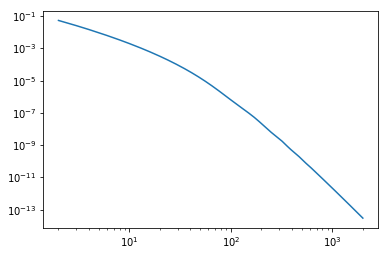

In [113]:
plt.plot(ell_, Cl33)
plt.loglog()

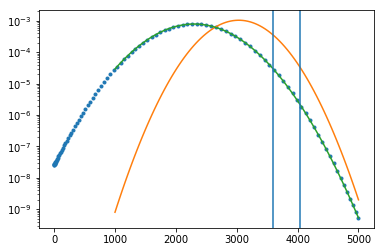

In [103]:
txi = np.linspace(1000, 5000, 100)
plt.plot(t_*txi, Wgauss(t_*txi, chi_z(1)), '.')
plt.plot(txi, Wgauss(txi, chi_z(1.5)))
plt.plot(txi, Wgauss(txi, chi_z(1)))
plt.axvline(chi_z(2.5))
plt.axvline(chi_z(2))
plt.yscale('log')